In [1]:
# Imports needed for the presentation
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
from IPython.display import Image
from tko.sonifying import sonify
from tko.selecting import select
from tko.utils import tokyo_kion, play_midifile

<div style="text-align: center">
<h1>東京気温音 <b>Tōkyō kion-on</b></h1>
</div>
<div style="text-align: center">
<h2><b>Query-Based Generative Sonification of Atmospheric Data</b></h2>
</div>
<div style="text-align: center"> <h3>S. Kalonaris</h3></div>
<div style="text-align: center"> <h4>Music Information Intelligence Team, Center for Advanced Intelligence Project (AIP), RIKEN</h4></div>

### 1. Introduction

### *mappings will follow simple intuitive basics, e.g., temperature to pitch, location to spatial rendering, etc., and the sound design shall evoke climate associations that are straightforward, e.g., as known from weather conditions*

<br> 
(Goudarzi 2014, p.11)
<br>

---
<small>V. Goudarzi, "Contextual Inquiry for a Climate Audio Interface," in Human-Computer Interfaces and Interactivity: Emergent Research and Applications, P. Isaas and K. Blashki, Eds. IGI Global, 2014</small>

* How about air temperature?

* Does this strategy hold well for linear growth models?

* What are the musical implications of rescaling numerically modest temperature degree differences (e.g., the nefarious 1.5 &deg;C) to auditorily convey a perceptual difference?

Foregrounding **aesthetic concerns** revolving around notions of **surrogacy** (Kalonaris & Zannos 2021) and leaning towards _**sonification abstraite**_ (Vickers & Hogg 2006), this work presents a query-based model of auditory display where a more subtle correspondence is sought.

<br>

---
<small>S. Kalonaris and I. Zannos, "High-Order Surrogacy for the Audiovisual Display of Dance," in Proceedings of the International Conference on Auditoru Display, 2021</small>

<small>P. Vickers and B. Hogg, "Sonification Abstraite/Sonification Concrète: An ‘Aesthetic Perspective Space’ for Classifying Auditory Displays in the Ars Musica Domain," in Proceedings of the International Conference on Auditory Display, 2006</small>


### 2. Related Work

#### Sonification of ANN's activation functions activity

<br>

---

<small>F. C. Halac and M. Delgadino, "DreamSound: Deep Activation Layer Sonification," in Proceedings of the International Conference on Auditory Display, 2021.</small>

#### ANNs for atmospheric data sonification

<br>

---
<small>S. Roddy and B. Bridges, "The Design of a Smart City Sonification System Using a Conceptual Blending and Musical Framework, Web Audio and Deep Learning Techniques," in Proceedings of the International Conference on Auditory Display, 2021.

### 3. Model

_Tōkyō kion-on_ can be considered both a **MBSon** and a **PMSon** model

* _MBSon_: the data of interest is explored via user interaction with the generative musical output of an ANN conditioned upon atmospheric data.

* _PMSon_: arbitrary mapping between the (processed) atmospheric data and the ANN's hyper-parameters. 

#### 3.1 Data

##### Music Data

A small dataset (46) of public domain Japanese melodies in `.musicxml` format hosted online

<br>

---

<small>http://www.daisyfield.com/music/htm/-genres/japan.htm/</small>

##### Atmospheric Data

Obtained from the *Japan Meteorological Agency*’s website, using the monthly mean daily maximum temperature table.

<br>

---

<small>https://www.data.jma.go.jp</small><br>
<small>https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47662&view=2</small>

In [2]:
# make dataframe and obtain the normalized vectors that will be used by the sonification model
df, notes_temp, duration_temp = tokyo_kion()
# visualize the first 5 entries of the dataframe
df.head()

Year  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0  1876  6.6   8.2  13.6  17.5  21.7  22.8  28.6  31.6  26.8  20.4  15.8   
1  1877  8.8   8.8  11.3  19.1  21.5  26.0  31.0  30.5  25.8  21.3  14.4   
2  1878  7.2   7.1  12.9  16.2  22.7  24.1  29.8  28.5  26.3  20.2  14.1   
3  1879  9.0  10.9  13.0  17.1  21.9  25.2  30.4  31.1  25.4  19.4  15.7   
4  1880  8.8  10.1  13.8  16.7  22.6  23.9  28.0  29.5  27.0  21.6  16.8   

    Dec  Annual  
0  11.0    18.7  
1  10.2    19.1  
2  10.9    18.3  
3  14.0    19.4  
4  11.1    19.2

The ``duration_temp`` is a vector obtained by normalizing the annual mean daily maximum temperature. 

In [3]:
print("Top 3 highest annual mean temperature years:")
list(df.iloc[np.argsort(1-duration_temp)[:3]]["Year"].values)    

Top 3 highest annual mean temperature years:


[2021, 2004, 2018]

The ``notes_temp`` looks at each year's forward difference of the monthly mean temperature, and then calculates the _cosine similarity_ between such vector and the vector corresponding to the first year recorded (1876).

In [4]:
print("Top 3 most dissimilar years:")
list(df.iloc[np.unravel_index(np.argsort(1-notes_temp), notes_temp.shape)[0][:3]]["Year"].values)

Top 3 most dissimilar years:


[1890, 1980, 1946]

#### 3.2 Architecture

**LSTM**s are chains of connected modules called units. Each unit comprises 4 layers: three sigmoid and one hyperbolic tangent. _Tōkyō kion-on_ uses 256 such units and employs the attention mechanism, which overcomes **RNN**s limitations in the encoder-decoder architecture by allowing the network to learn where to attend/focus most in the output sequence. 

<center><img src="imgs/lstm_cell.png" style="display=block; margin:auto"/></center>

#### 3.3 Temperature (for the LSTM)

Apply an activation function to a logit vector $z$ where $z=(z_{1},\ldots,z_{n})$ to produce a probability vector $q=(q_{1},\ldots,q_{n})$ over predicted output classes by comparing $z_{i}$ with the other logits. 

_Softmax_ is normally the activation function of choice for the last layer of a neural network.
In LSTMs, the temperature hyper-parameter $T$ controls the randomness of the predictions, effectively being a scaling factor for the logits, when computing the softmax output.

$$q_{i} = \frac{\exp(\frac{z_{i}}{T})}{\sum_{j}^{n}\exp(\frac{z_{j}}{T})}$$

### 4. Examples

#### Single year: default hyper-parameters

#### 1876

In [5]:
# sonify the reference year (1876)
s1876, _ = sonify(year=1876)

In [6]:
# listen
play_midifile('../tko/out/mid/tokyokionon_1876_A4_quarter_0.0_0.261_16_32_32.mid')

**Note** that, while the saved file correctly features a _Shamisen_ sound, the interactive notebook rendition loses such info and renders the melody with a Piano sound.

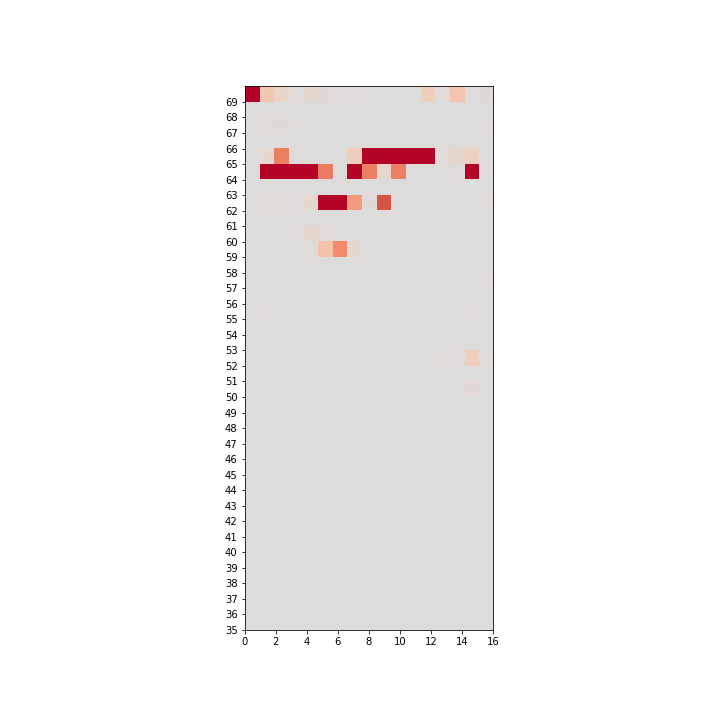

In [7]:
# Inspect the predictions' distribution
Image(filename='../tko/out/viz/predictions_1876_A4_quarter_0.0_0.261_16_32_32.png') 

The darker (red) is a note at any given time step, the more likely it is that the model will select it.

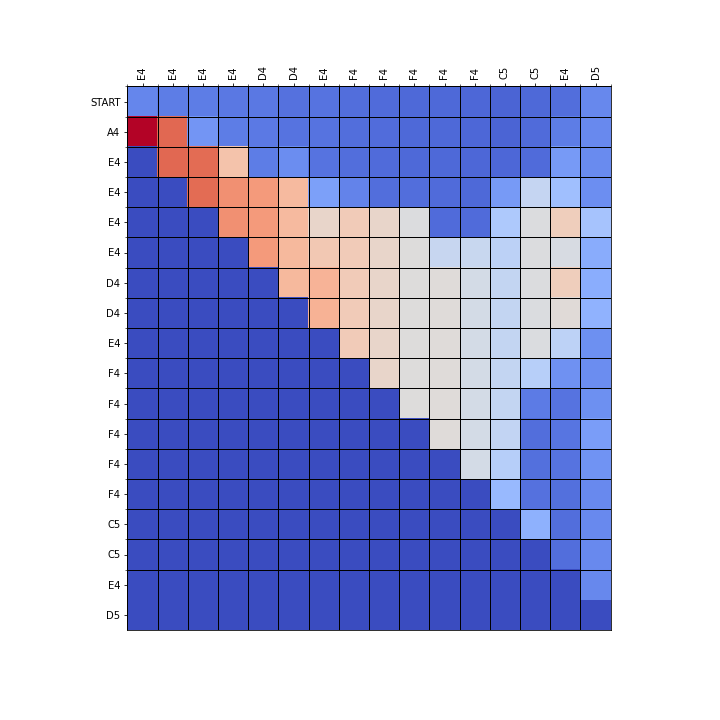

In [8]:
# Inspect the attention matrix

Image(filename='../tko/out/viz/attention_1876_A4_quarter_0.0_0.261_16_32_32.png') 

The amount of _redness_ of a cell is proportional to the attention given to the hidden state of the model corresponding to the $y$ position, when predicting the note on the $x$ position.

#### 1980

In [9]:
s1980, _ = sonify(year=1980)

In [10]:
play_midifile('../tko/out/mid/tokyokionon_1980_A4_quarter_0.857_0.37_16_32_32.mid')

#### Single year: custom hyper-parameters

#### 2021

In [11]:
# No priming seed
s2021, _ = sonify(year=2021, seed=[['START'],[0]], save=True)

In [12]:
play_midifile('../tko/out/mid/tokyokionon_2021_START_zero_0.239_1.0_16_32_32.mid')

#### Multiple year (range)

#### 1876-1886

In [13]:
# First 10 years worth of sonification
_, s1876_1886 = select(year_span=[1876,1886], seed=[["A4"],[1.0]], max_extra_notes=8, max_seq_len=8, seq_len=8)

In [14]:
play_midifile('../tko/out/mid/tokyokionon_1876-1886_A4_quarter_8_8_8.mid')

### 5. Discussion

#### Idiosyncrasies
* non-linear exploration of the data of interest
* creative use beyond empirically-based sonification
* meaning-making vs meaning-finding/-carrying

#### To do's

* gather larger training corpus
* experiment with different ANNs models
* web-based version